## Описание проекта


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Задача: Построить модель для такого предсказания чтобы значение метрики RMSE на тестовой выборке было не больше 48.


# Шаг. Изучить общую информацию

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
# В переменную дата запишем полученный датасет
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'
if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print("Проверьте правильность пути к датасету")

In [3]:
# Отсортируем и ресемплируем данные
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [4]:
# Выведем основные данные и первые 5 строк изначального датасета
print(data.info())
data.head(2)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85


# Шаг. Анализ данных

In [5]:
display(data.sample(3))
display(data.describe())

,num_orders
datetime,
2018-04-10 21:00:00,53
2018-07-19 03:00:00,161
2018-07-06 07:00:00,27


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [6]:
print('Количество записей, где не было ни одного заказа', data.loc[data['num_orders']==0]['num_orders'].count())

Количество записей, где не было ни одного заказа 1


В нашем распоряжении данные за период с марта по август 2018 года. Всего около 4 тыс. записей.

Исходя из представленных данных, можно сделать вывод, что в выборке присутствует только одна запись, где не было ни одного заказа такси. При этом 50% всех значений заказв находится в промежутке от 54 до 107 вызовов. Далее рассмотрим график распределния количества вызовов, скользящее среднее и стандартное отклонение по скользящему окну.

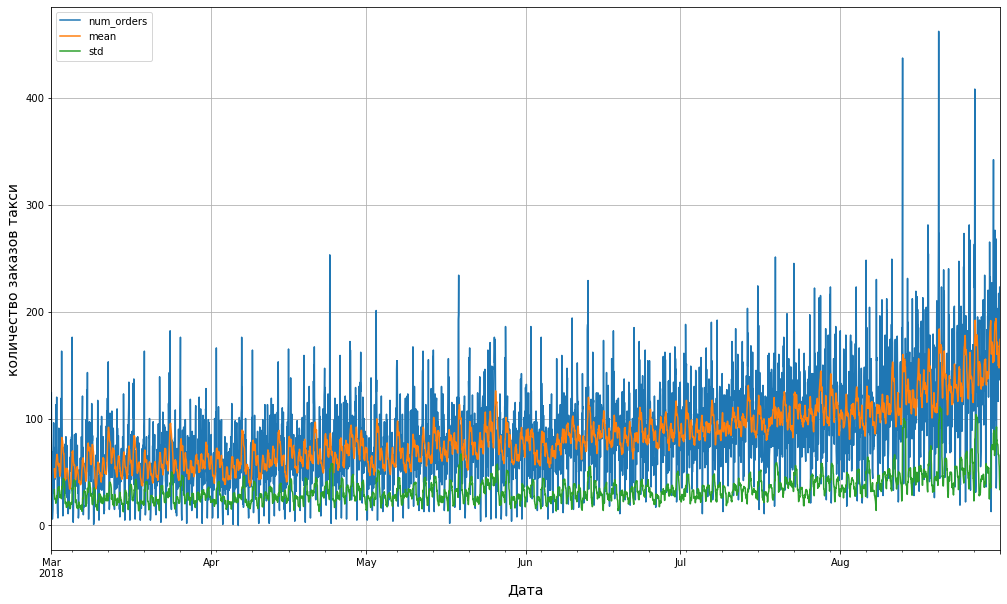

In [7]:
df = data.copy()
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(17, 10),grid=True)
plt.ylabel('количество заказов такси', size=14)
plt.xlabel('Дата', size=14)
plt.show()

In [8]:
del df

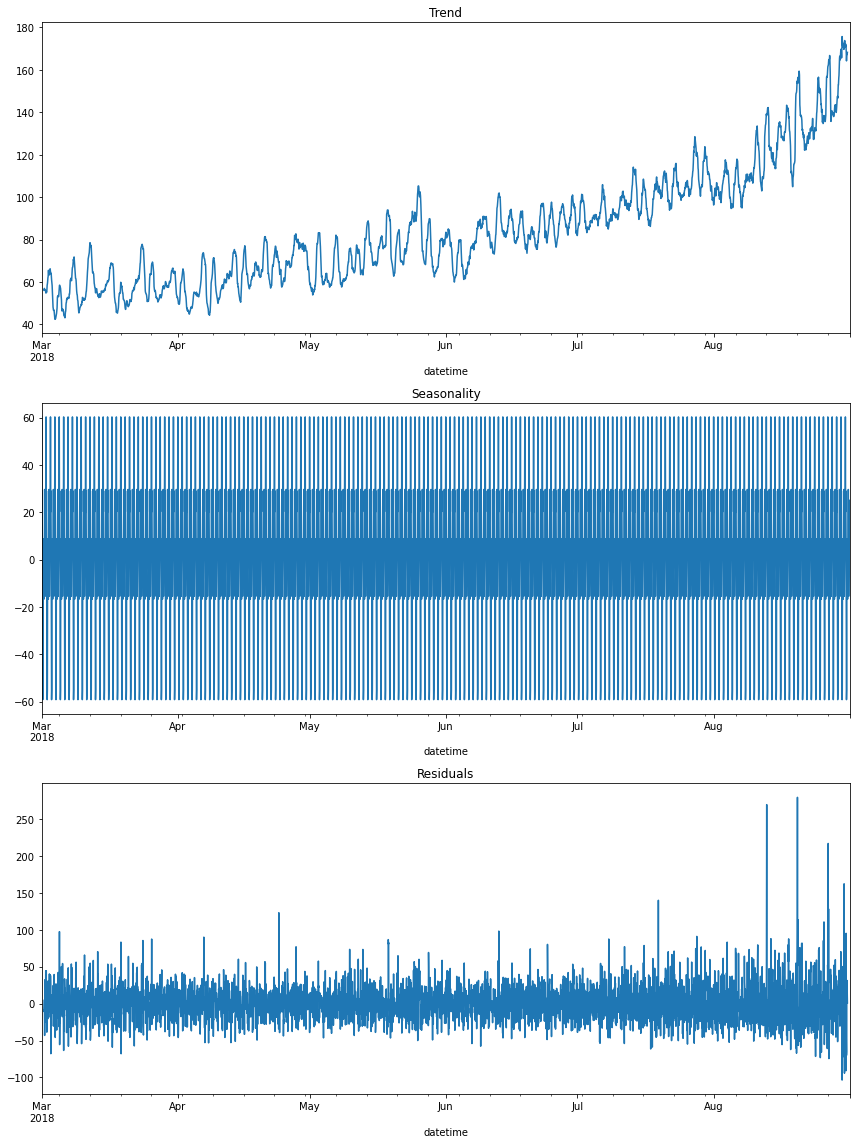

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Анализ полученных графиков позволяет утверждать, что в имеющемся наборе данных существует тренд роста количества заказов. 

Однако, говорить что-либо о сезонности по построенному графику невозможно. Для изучения сезонности построим график за первые 4 дня марта.

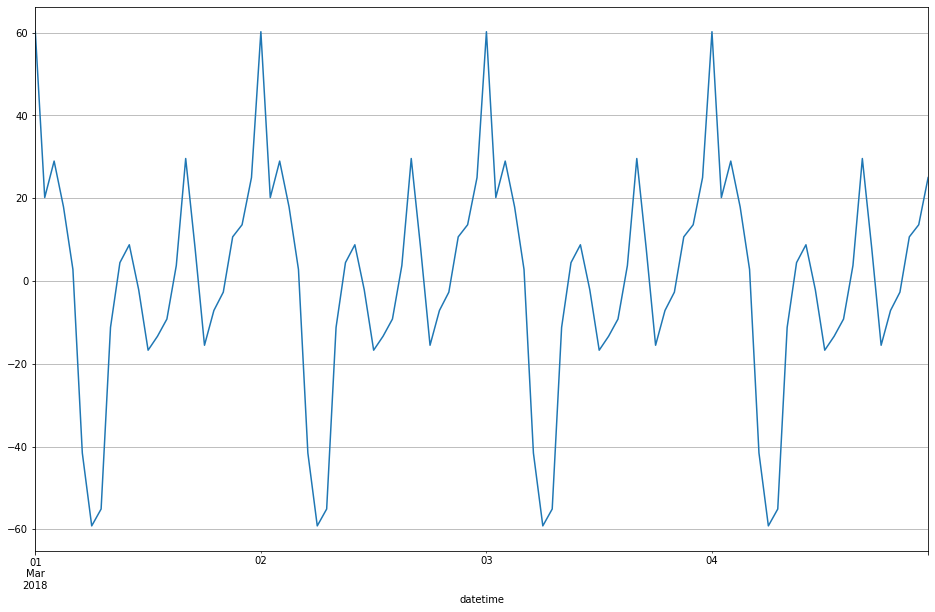

In [10]:
decomposed = decomposed.seasonal['2018-03-01':'2018-03-04'].plot(figsize=(16, 10),grid=True)

Полученный график позволяет говорить о дневной сезонности.

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Отлично!
</div>

Обратим внимание, что на графике присутствуют выбросы. Можно заметить аномальный выбросы в апреле, мае, июне и августе. В данном исследовании эти выбросы не будут корректироваться т.к. на представленном графике мы видим, что подобные выбросы случаются достаточно регулярно. Способность предсказывать подобные выбросы одна из задач модели, которую предстоит построить.


Обратим внимание, что присутствует тренд на рост количества заказов такси. При этом, очевидно, говорить о сезонности не представляется возможным всвязи с временным окном предоставленной выборки.

При этом, подобное представление данных позволяет утверждать, что данный временной ряд не является стационарным, т.к. у него увеличивается среднее значение. Чтобы сделать ряд более стационарным, найдём разности его значений.

In [11]:
df2 = data - data.shift(fill_value=0)
data_shift = data.copy()
data_shift['shift'] = data_shift - data_shift.shift(fill_value=0)

In [12]:
data_shift.sample()

,num_orders,shift
datetime,,
2018-05-10 14:00:00,90,38


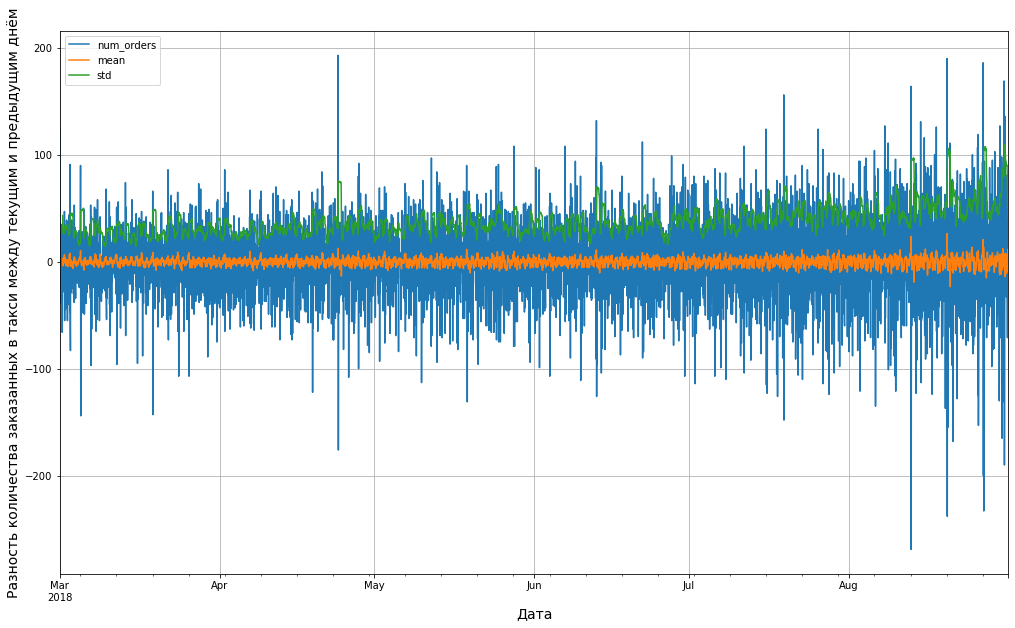

In [13]:
df2['mean'] = df2['num_orders'].rolling(15).mean()
df2['std'] = df2['num_orders'].rolling(15).std()
df2.plot(figsize=(17, 10),grid=True)
plt.ylabel('Разность количества заказанных в такси между текущим и предыдущим днём', size=14)
plt.xlabel('Дата', size=14)
plt.show()

In [14]:
del df2

## Вывод

После проведённых преобразований, согласно данным, отображённым на графике выше, можно сделать вывод, что ряд стал более стационарным, следовательно пригодным к построению предсказаний.

# Шаг. Обучение моделей

Перед построением моделей необходимо добавить новые признаки, которые позволят улучшить качество предсказаний. Затем разбить набор на обучающую, валидационную и тестовую выборки.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [16]:
df = make_features(data, 32, 32)

In [17]:
df.sample()

,num_orders,day,month,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-12 14:00:00,65,12,7,14,3,80.0,126.0,80.0,116.0,108.0,...,102.0,126.0,59.0,95.0,101.0,104.0,76.0,28.0,81.0,94.25


In [18]:
test = adfuller(data)
print ('adf:', test[0])
print ('p-value:', test[1])
print ('Critical values:', test[4])
if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf: -3.068924289027951
p-value: 0.028940051402613316
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


In [19]:
df = df.dropna()

In [20]:
features = df.drop(['num_orders'],axis=1)
target = df['num_orders']

In [21]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target,shuffle=False, train_size= .80,random_state=12345)
features_valid, features_test,target_valid, target_test = train_test_split(
    features_test, target_test,shuffle=False, train_size= .50,random_state=12345)

Удостоверимся, что разбиение выполнено корректно:

In [22]:
print('features_train shape',features_train.shape)
print('target_train shape',target_train.shape)
print('features_test shape', features_test.shape)
print('target_test shape', target_test.shape)
print('features_valid shape', features_valid.shape)
print('target_valid shape', target_valid.shape)

features_train shape (3507, 37)
target_train shape (3507,)
features_test shape (439, 37)
target_test shape (439,)
features_valid shape (438, 37)
target_valid shape (438,)


## Дерево решений

In [23]:
%%time
best_tree_model = None
best_tree_result = 10000
best_tree_depth = 0
for depth in range(1, 20):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid, squared=False)
    if result < best_tree_result:
        best_tree_model = model
        best_tree_result = result
        best_tree_depth = depth

print('RMSE наилучшей модели на валидационной выборке:', round(best_tree_result), 'Глубина дерева:', best_tree_depth)

RMSE наилучшей модели на валидационной выборке: 36 Глубина дерева: 8
CPU times: user 1.07 s, sys: 288 ms, total: 1.36 s
Wall time: 296 ms


## Случайный лес

In [61]:
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [25]:
%%time
model_forest = RandomForestRegressor()
parametrs = { 'n_estimators': range (10, 100, 10),
              'max_depth': range (1,17, 2),
              'min_samples_split': range (2,10,1) }
grid = GridSearchCV(model_forest, parametrs, cv=tscv)
grid.fit(features_train, target_train)

grid.best_params_

CPU times: user 14min 34s, sys: 2.77 s, total: 14min 36s
Wall time: 14min 37s


{'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 90}

In [62]:
model_forest = RandomForestRegressor(max_depth = 13, 
                                     min_samples_leaf= 2, 
                                     min_samples_split= 9,
                                     n_estimators= 90)

model_forest.fit(features_train, target_train)

predictions_valid = model_forest.predict(features_valid)

forest_result = mean_squared_error(target_valid, predictions_valid, squared=False)
print('RMSE наилучшей модели на валидационной выборке:', round(forest_result))

RMSE наилучшей модели на валидационной выборке: 33


## Линейная регрессия

In [27]:
model_lenear = LinearRegression()
model_lenear.fit(features_train, target_train)
predictions_lenear_valid = model_lenear.predict(features_valid)

result_lenear = mean_squared_error(target_valid, predictions_lenear_valid, squared=False)

print('RMSE модели линейной регрессии на валидационной выборке:', round(result_lenear))

RMSE модели линейной регрессии на валидационной выборке: 40


## Модель градиентного бустинга с библиотекой LightGBM

In [28]:
%%time
model_lgbmr = LGBMRegressor()
parametrs = { 'boosting_type': ['gbdt', 'dart', 'goss'],
              'n_estimators': range (100, 200, 10),
              'learning_rate': np.arange(.001,.1, .05),
              'max_depth': range (1,10, 1),
              'num_leaves': range (28,2**7,2) }
grid = GridSearchCV(model_lgbmr, parametrs, cv=tscv)
grid.fit(features_train, target_train)

grid.best_params_

CPU times: user 15h 5min 14s, sys: 1h 28min 52s, total: 16h 34min 6s
Wall time: 2h 14min 16s


{'boosting_type': 'gbdt',
 'learning_rate': 0.051000000000000004,
 'max_depth': 9,
 'n_estimators': 90,
 'num_leaves': 30}

In [26]:
model_lgbmr = LGBMRegressor(boosting_type= 'gbdt', 
                            learning_rate= 0.051000000000000004,
                            max_depth= 11,
                            n_estimators= 90,
                            num_leaves= 42)
model_lgbmr.fit(features_train, target_train)

predictions_lgbmr = model_lgbmr.predict(features_valid)

result_lgbmr = mean_squared_error(target_valid, predictions_lgbmr, squared=False)

print('RMSE градиентного бустинга с параметрами по умолчанию на валидационной выборке:', round(result_lgbmr))

RMSE градиентного бустинга с параметрами по умолчанию на валидационной выборке: 32


## Проверка на адекватность

In [30]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

predictions_dummy = dummy_regr.predict(features_valid)

result_dummy = mean_squared_error(target_valid, predictions_dummy, squared=False)

print('RMSE тестовой модели на валидационной выборке:', round(result_dummy))

RMSE тестовой модели на валидационной выборке: 58


## Проверка лучшей модели на тестовой выборке

In [28]:
features_test_append = features_valid.append(features_test)
target_test_append = target_valid.append(target_test)

In [29]:
print('Признаки соединены правильно:',features_test_append.index.is_monotonic)
print('Целевые признаки соединены правильно:',target_test_append.index.is_monotonic)

Признаки соединены правильно: True
Целевые признаки соединены правильно: True


In [30]:
predictions_lgbmr = model_lgbmr.predict(features_test_append)

result_lgbmr = mean_squared_error(target_test_append, predictions_lgbmr, squared=False)

print('RMSE градиентного бустинга с параметрами по умолчанию на валидационной выборке:', round(result_lgbmr))

RMSE градиентного бустинга с параметрами по умолчанию на валидационной выборке: 44


In [49]:
features_test.sample()

,day,month,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-30 17:00:00,30,8,17,3,254.0,156.0,91.0,154.0,173.0,156.0,...,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,159.0,166.916667


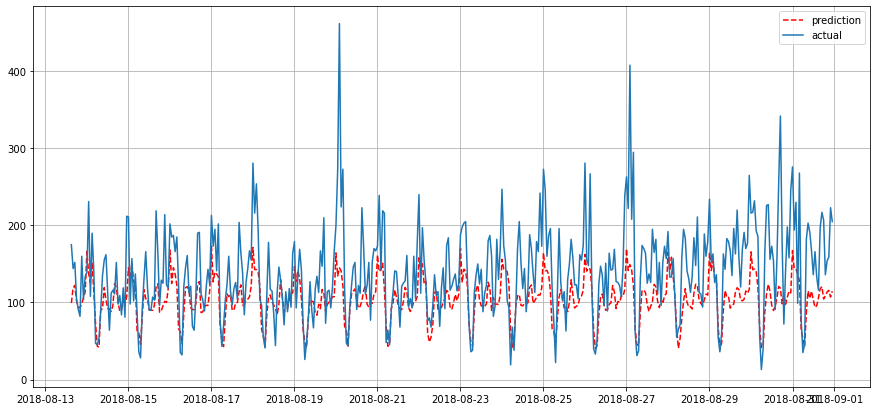

In [75]:
plt.figure(figsize=(15, 7))
plt.plot(pd.Series(predictions_lgbmr, index = target_test.index), "r--",label = 'prediction')
plt.plot(target_test, label="actual")
plt.legend(loc="best")
plt.grid(True)

# Шаг. Вывод

Задачей данного исследования  является прогноз количество заказов такси на следующий час. Для анализа данных была предоставлена таблица с значениями количества вызовов такси в период с марта по август 2018.

Для выполнения поставленной задачи были подготовлены и обучены модели дерева решений, случайного леса, линейной регрессии и градиентного бустинга.

По итогу проделанной работы была построена модель, которая показала RMSE равное 46 на валидационной выборке и 34 на тестовой выборке.